In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [2]:
# imports 
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

./PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
./PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
# load pre-trained RBM and pre-compute the partition functions
path = './trained_RBMs/'
file_name = 'RBM_SC8.data'
RBM_sc = RBM_utils.loadRBM(path + file_name)
RBM_sc.AIS(n_betas=40000,verbose=0)

file_name = 'RBM_SU8.data'
RBM_su = RBM_utils.loadRBM(path + file_name)
RBM_su.AIS(n_betas=40000,verbose=0)

Mismatch dimensions (1000, 80), [10, 80], reinitializating I
Mismatch dimensions (1000, 20, 4), [10, 20, 4], reinitializating I
Mismatch dimensions (500, 70), [10, 70], reinitializating I
Mismatch dimensions (500, 20, 4), [10, 20, 4], reinitializating I


(96.87543, 0.013853134620118347)

In [4]:
# load round 8 data
path = './data/'
filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
full_data_8 = np.repeat(all_data_8, counts_8, axis=0)

# split left and right data
seqs_8_l_2num, counts_8_l = np.unique(full_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})

seqs_8_r_2num, counts_8_r = np.unique(full_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})

# put both rounds together
all_data_8_lr = pd.concat([all_data_8_l, all_data_8_r])
all_data_8_lr = all_data_8_lr.reset_index(drop=True)
all_data_8_lr = all_data_8_lr.groupby(by=["sequence"], as_index=False).sum()
all_data_8_lr = all_data_8_lr.sort_values(by='counts', ascending=False).reset_index(drop=True)
all_seq_8_lr = DNA_utils.seq2num(all_data_8_lr["sequence"].to_list())
counts_8_lr = all_data_8_lr['counts'].to_numpy()

In [5]:
# compute loglikelihood for round 8 sequences
all_data_8_lr['loglikelihood'] = RBM_su.likelihood(all_seq_8_lr)
all_data_8_lr['loglikelihood_SC'] = RBM_sc.likelihood(all_seq_8_lr)

In [7]:
# load experimental data
filename = './data/Aptamer_Exp_Results.csv'
exp_df = pd.read_csv(filename)
exp_rounds = []
for l in exp_df['label']:
    if 'd' in l:
        exp_rounds.append(1)
    elif ('r' in l) and (int(l[1:]) <= 23):
        exp_rounds.append(2)
    elif 'p' in l:
        exp_rounds.append(3)
    else:
        exp_rounds.append(4)
exp_df['experimental_round'] = exp_rounds
# add ThA, ThD with exp round -1
t_df1 = pd.DataFrame({"label":["ThA"], "sequence":["AGGGATGATGTGTGGTAGGC"], 
                     "binder":["B"],"binding site":["AB"], "experimental_round":[-1]})
# add ThB with exp round -1
t_df2 = pd.DataFrame({"label":["ThB"], "sequence":["AGGGTAGGTGTGGATGATGC"], 
                     "binder":["B"],"binding site":["AB"], "experimental_round":[-1]})
# add ThC with exp round -1
t_df3 = pd.DataFrame({"label":["ThC"], "sequence":["TAGGTTTTGGGTAGGGTGGT"], 
                     "binder":["B"],"binding site":["CD"], "experimental_round":[-1]})
# add ThD with exp round -1
t_df4 = pd.DataFrame({"label":["ThD"], "sequence":["GTAGGATGGGTAGGGTGGTC"], 
                     "binder":["B"],"binding site":["CD"], "experimental_round":[-1]})
exp_df = pd.concat([t_df1, t_df2, t_df3, t_df4, exp_df])

exp_df["loglik"] = RBM_su.likelihood(DNA_utils.seq2num(exp_df["sequence"].to_list()))
exp_df["loglik_SC"] = RBM_sc.likelihood(DNA_utils.seq2num(exp_df["sequence"].to_list()))

# create 3 dataset: general binders and AB and CD specific binders, only rounds -1, 2 and 3 (so ThX, r<23, and p sequences)
allowed_rounds = [-1, 2, 3]
df_binders_AB = exp_df[(exp_df['experimental_round'].isin(allowed_rounds)) & (exp_df['binding site']=='AB')]
df_binders_CD = exp_df[(exp_df['experimental_round'].isin(allowed_rounds)) & (exp_df['binding site']=='CD')]

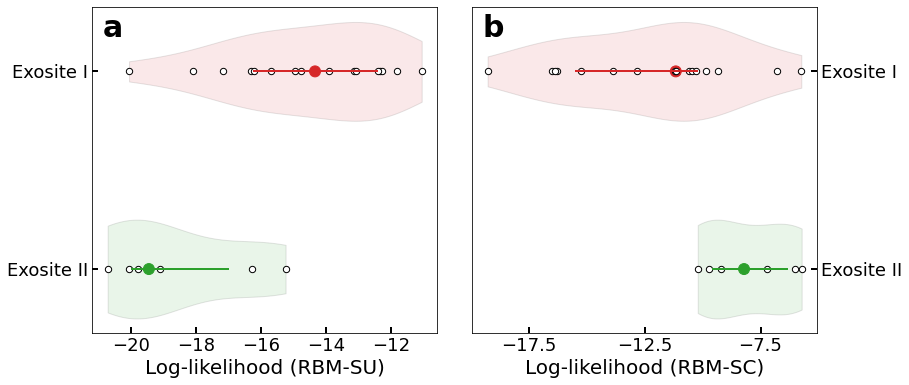

In [8]:
# two 2panel figs: first the two violin plots
# make figure
fig = plt.figure(figsize=(13, 6))
gs = fig.add_gridspec(ncols=2, nrows=1, hspace=0.1, wspace=0.1)

############################################################################################################################
ax2 = fig.add_subplot(gs[0,0])
data = np.array([df_binders_AB["loglik"].to_numpy(), df_binders_CD["loglik"].to_numpy()])
parts = ax2.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False, vert=False)
for i,pc in enumerate(parts['bodies']):
    if i==0:
        pc.set_facecolor('C2')
        pc.set_edgecolor('black')
        pc.set_alpha(0.1)
    elif i==1:
        pc.set_facecolor('C3')
        pc.set_edgecolor('black')
        pc.set_alpha(0.1)        
        
quartile1, medians, quartile3 = np.array([np.percentile(d, [25, 50, 75]) for d in data]).T
inds = np.arange(1, len(medians) + 1)
ax2.scatter(medians, inds, marker='o', color=['C2', 'C3'], s=120, zorder=1)
ax2.hlines(inds, quartile1,  quartile3, color=['C2', 'C3'], linestyle='-', lw=2, zorder=3)
ax2.scatter(data[0], np.full(len(data[0]),1), marker='o', color='white', s=40, edgecolors='k', zorder=2)
ax2.scatter(data[1], np.full(len(data[1]),2), marker='o', color='white', s=40, edgecolors='k', zorder=2)

ax2.set_xlabel("Log-likelihood (RBM-SU)", size=20)
ax2.set_yticks([1,2])
ax2.set_yticklabels(["Exosite II", "Exosite I"])
ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax2.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax2.tick_params(axis='both', labelsize=18)
ax2.text(0.03, 0.91, 'a', fontsize=30, 
         color='k', weight='bold', transform=ax2.transAxes)
############################################################################################################################
ax2 = fig.add_subplot(gs[0,1])
data = np.array([df_binders_AB["loglik_SC"].to_numpy(), df_binders_CD["loglik_SC"].to_numpy()])
parts = ax2.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False, vert=False)
for i,pc in enumerate(parts['bodies']):
    if i==0:
        pc.set_facecolor('C2')
        pc.set_edgecolor('black')
        pc.set_alpha(0.1)
    elif i==1:
        pc.set_facecolor('C3')
        pc.set_edgecolor('black')
        pc.set_alpha(0.1)        
        
quartile1, medians, quartile3 = np.array([np.percentile(d, [25, 50, 75]) for d in data]).T
inds = np.arange(1, len(medians) + 1)
ax2.scatter(medians, inds, marker='o', color=['C2', 'C3'], s=120, zorder=1)
ax2.hlines(inds, quartile1,  quartile3, color=['C2', 'C3'], linestyle='-', lw=2, zorder=3)
ax2.scatter(data[0], np.full(len(data[0]),1), marker='o', color='white', s=40, edgecolors='k', zorder=2)
ax2.scatter(data[1], np.full(len(data[1]),2), marker='o', color='white', s=40, edgecolors='k', zorder=2)

ax2.set_xlabel("Log-likelihood (RBM-SC)", size=20)
ax2.set_yticks([1,2])
ax2.set_yticklabels(["Exosite II", "Exosite I"])
ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax2.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax2.tick_params(axis='both', labelsize=18)
ax2.text(0.03, 0.91, 'b', fontsize=30, 
         color='k', weight='bold', transform=ax2.transAxes)
ax2.set_xticks([-17.5, -12.5, -7.5])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
############################################################################################################################